<a href="https://colab.research.google.com/github/Virppsa/AI-neural-networks/blob/main/Kursinis(AI_collapse).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DI modelių kolapso tematika paruoštas tyriamasis darbas.
Tikslas - vizualiai atpažinti neuroninio tinklo VAE kolapsą naudojant MNIST duomenis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras.datasets import mnist
from keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, Flatten, Dense, Lambda
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()
np.random.seed(237)

In [5]:
from google.colab import drive

In [8]:
from keras.datasets import mnist

In [6]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
# Load Dataset
(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data()

In [13]:
num_labels = len(np.unique(Y_train))
num_labels

10

In [16]:
# Normalize and reshape
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(-1,28,28,1)

X_valid = X_valid.astype('float32') / 255.
X_valid = X_valid.reshape(-1,28,28,1)

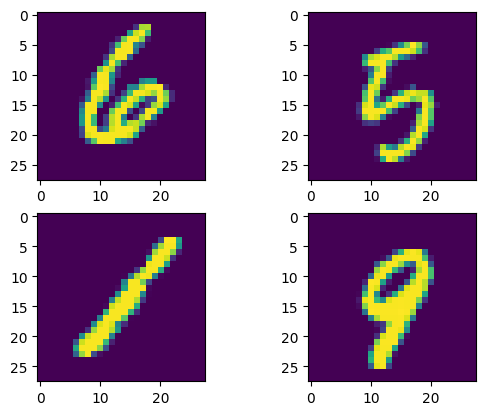

In [17]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[13][:,:,0])

plt.subplot(222)
plt.imshow(X_train[690][:,:,0])

plt.subplot(223)
plt.imshow(X_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(X_train[42013][:,:,0])
plt.show()


In [30]:
#Model construction:--------------------------------------------------------

# img_shape = (28, 28, 1)    # for MNIST
# batch_size = 16
# latent_dim = 2  # Number of latent dimension parameters

# # Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
# input_img = Input(shape=img_shape)

# x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
# x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)
# x = Conv2D(64, 3, padding='same', activation='relu')(x)

# # need to know the shape of the network here for the decoder
# shape_before_flattening = K.int_shape(x)

# x = Flatten()(x)
# x = Dense(32, activation='relu')(x)

# # Two outputs, latent mean and (log)variance
# z_mu = Dense(latent_dim)(x)
# z_log_sigma = Dense(latent_dim)(x)




import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.models import Model

# Model construction:--------------------------------------------------------
img_shape = (28, 28, 1)    # for MNIST
#batch_size = 16
batch_size = 256
latent_dim = 2  # Number of latent dimension parameters

# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

# Capture shape before flattening
shape_before_flattening = x.shape  # Use .shape instead of K.int_shape

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

# Print the captured shape
print("Shape before flattening:", shape_before_flattening)


Shape before flattening: (None, 14, 14, 64)


In [31]:
# # sampling function
# def sampling(args):
#     z_mu, z_log_sigma = args
#     epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
#                               mean=0., stddev=1.)
#     return z_mu + K.exp(z_log_sigma) * epsilon

# # sample vector from the latent distribution
# z = Lambda(sampling)([z_mu, z_log_sigma])



from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

# Sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mu + K.exp(0.5 * z_log_sigma) * epsilon  # Use 0.5 to scale log_sigma correctly

# Explicitly define the output shape
def sampling_output_shape(input_shape):
    return input_shape[0]  # The output shape is the same as z_mu's shape

# Sample vector from the latent distribution
z = Lambda(sampling, output_shape=sampling_output_shape)([z_mu, z_log_sigma])


In [32]:
# # decoder takes the latent distribution sample as input
# decoder_input = Input(K.int_shape(z)[1:])

# # Expand to 784 total pixels
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# # reshape
# x = Reshape(shape_before_flattening[1:])(x)

# # use Conv2DTranspose to reverse the conv layers from the encoder
# x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
# x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# # decoder model statement
# decoder = Model(decoder_input, x)

# # apply the decoder to the sample from the latent distribution
# z_decoded = decoder(z)


from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
import numpy as np

# Decoder takes the latent distribution sample as input
decoder_input = Input(shape=(latent_dim,))
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)

# Reverse the Conv layers from the encoder
x = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu')(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# Decoder model
decoder = Model(decoder_input, x, name="decoder")

# Apply decoder to the sampled latent variable
z_decoded = decoder(z)


In [33]:
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.losses import binary_crossentropy

# class CustomVariationalLayer(Layer):
#     def call(self, inputs):
#         x, z_decoded = inputs
#         # Flatten for reconstruction loss
#         x_flat = tf.reshape(x, shape=(-1, np.prod(img_shape)))
#         z_decoded_flat = tf.reshape(z_decoded, shape=(-1, np.prod(img_shape)))

#         # Reconstruction loss
#         reconstruction_loss = tf.reduce_mean(
#             tf.reduce_sum(binary_crossentropy(x_flat, z_decoded_flat), axis=-1)
#         )

#         # KL Divergence loss
#         kl_loss = -0.5 * tf.reduce_mean(
#             1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma)
#         )

#         # Add losses
#         self.add_loss(reconstruction_loss + kl_loss)
#         return x  # Pass the input forward



class CustomVariationalLayer(Layer):
    def call(self, inputs):
        x, z_decoded, z_mu, z_log_sigma = inputs
        # Flatten for reconstruction loss
        x_flat = tf.reshape(x, shape=(-1, np.prod(img_shape)))
        z_decoded_flat = tf.reshape(z_decoded, shape=(-1, np.prod(img_shape)))

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(binary_crossentropy(x_flat, z_decoded_flat), axis=-1)
        )

        # KL Divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_sigma - tf.square(z_mu) - tf.exp(z_log_sigma)
        )

        # Add losses
        self.add_loss(reconstruction_loss + kl_loss)
        return x  # Pass the input forward


In [34]:
# Apply the custom loss layer
y = CustomVariationalLayer()([input_img, z_decoded, z_mu, z_log_sigma])

In [35]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 14, 14, 64)     │         36,928 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 12544)          │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │        401,440 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │             66 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 2)              │             66 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 2)              │              0 │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Functional)      │ (None, 28, 28, 1)      │         93,313 │ lambda_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_variational_layer… │ (None, 28, 28, 1)      │              0 │ input_layer_4[0][0],   │
│ (CustomVariationalLayer)  │                        │                │ decoder[0][0],         │
│                           │                        │                │ dense_6[0][0],         │
│                           │                        │                │ dense_7[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 587,557 (2.24 MB)

 Trainable params: 587,557 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

#Treniravimas

In [36]:
num_epochs = 20